what is the depth of the tree to be constructed?(Choose something less than 5 for faster result)
8
******************************PART 1****************************************
depth: 8 ; split_no: 1 ; r2_score: 0.9990864618126504
depth: 8 ; split_no: 2 ; r2_score: 0.9987541594838609
depth: 8 ; split_no: 3 ; r2_score: 0.9984566645694261
depth: 8 ; split_no: 4 ; r2_score: 0.9987695878131315
depth: 8 ; split_no: 5 ; r2_score: 0.9989443127805402
depth: 8 ; split_no: 6 ; r2_score: 0.9968370057439049
depth: 8 ; split_no: 7 ; r2_score: 0.9974656669474522
depth: 8 ; split_no: 8 ; r2_score: 0.9982309658933713
depth: 8 ; split_no: 9 ; r2_score: 0.9986221523214096
depth: 8 ; split_no: 10 ; r2_score: 0.9984901789263431


Maximum r_sq score= 0.9990864618126504  for split number= 1


The average accuracy over 10 [60:20:20] splits is  0.998365715629209


******************************PART 2****************************************
depth: 1 ;r2_score: 0.8524873768157473
depth: 2 ;r2_score: 0.9450081705

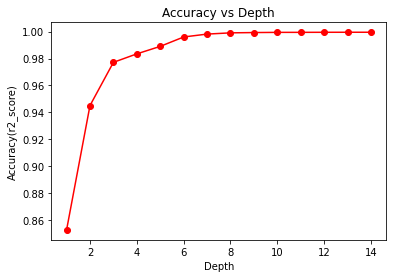

The best possible depth limit is: 14


***********************************PART 3*****************************************
MSE error on val_set before and after pruning:
MSE of Tree:        17,763
MSE of pruned Tree: 17,683

MSE error on test_set before and after pruning:
MSE of Tree:        73,942
MSE of pruned Tree: 73,882

Plot on test set


***********************************PART 4*****************************************
{'Recovered <= 445123': [{'Confirmed <= 478792': [{'Confirmed <= 52807': [{'Confirmed <= 14917': [{'Confirmed <= 7888': [{'Confirmed <= 2257': [{'Confirmed <= 671': [{'Confirmed <= 482': [{'Confirmed <= 78': [{'Recovered <= 4': [{'Country = Burma': [{'Confirmed <= 20': [{'Confirmed <= 14': [0.0,
                                                                                                                                                                                                                                                                                  

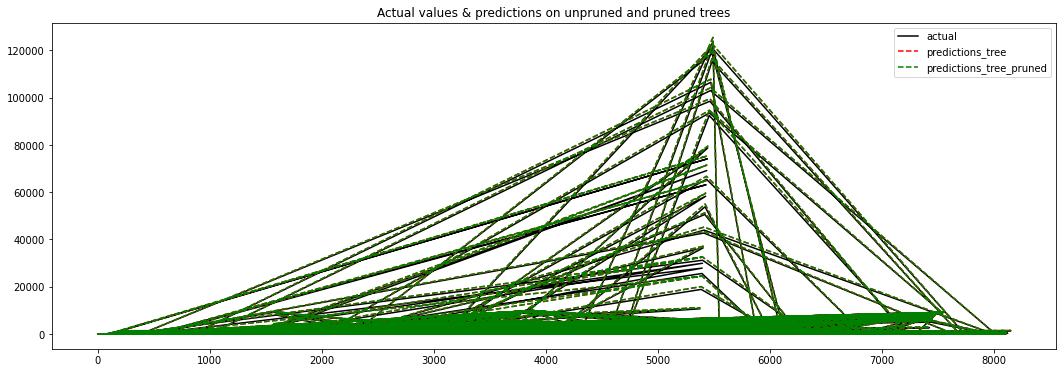

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot
from sklearn.metrics import r2_score
import seaborn as sns
import random
from pprint import pprint

def splitdataset(balance_data): 
  
    # Splitting the dataset into train and test 
    train_set = balance_data.sample(frac=0.6)
    test_set = (balance_data.drop(train_set.index)).sample(frac=0.5)
    val_set = balance_data.drop(test_set.index)
    return train_set, test_set, val_set    

def check_purity(data): 
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    if len(unique_classes) == 1:
        return True
    else:
        return False

def create_leaf(data):
    label_column = data[:, -1]
    leaf = np.mean(label_column)
    return leaf

def get_potential_splits(data):   
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

def divide_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

def evaluate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0  
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    return mse

def evaluate_overall_metric(data_below, data_above): 
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
    overall_metric =  (p_data_below * evaluate_mse(data_below) 
                     + p_data_above * evaluate_mse(data_above))
    return overall_metric

def determine_best_split(data, potential_splits):  
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = divide_data(data, split_column=column_index, split_value=value)
            current_overall_metric = evaluate_overall_metric(data_below, data_above)
            
            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

def det_type_of_feature(df):   
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

def decision_tree_regressor(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = det_type_of_feature(df)
        data = df.values
    else:
        data = df 

    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or ((counter == max_depth) and (max_depth > 0)):
        leaf = create_leaf(data)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = divide_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
         # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_regressor(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_regressor(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree  
    
def predict_example(example, tree):
    if isinstance(tree,dict): 
        question = list(tree.keys())[0]
        feature_name, comparison_operator, value = question.split(" ",2)
        if comparison_operator == "<=":
            if example[feature_name] <= float(value):
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # feature is categorical
        else:
            if str(example[feature_name]) == value:
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # base case
        if not isinstance(answer, dict):
            return answer

        # recursive part
        else:
            residual_tree = answer
            return predict_example(example, residual_tree)
    else:
        return tree
    
def make_predictions(df, tree):
    
    if len(df) != 0 and isinstance(tree,dict):
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()  
    return predictions

def calculate_r_squared(df, tree):    
    labels = df.label
    mean = labels.mean()
    predictions = df.apply(predict_example, args=(tree,), axis=1)
    return r2_score(labels, predictions)  

def filter_df(df, question):
    # feature, comparison_operator, value = question.split()
    feature, comparison_operator, value = question.split(" ",2)
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

def determine_leaf(df_train):
        return df_train.label.mean()

def determine_errors(df_val, tree):
    if isinstance(tree, dict):
        predictions = make_predictions(df_val, tree)
        actual_values = df_val.label
        return ((predictions - actual_values) **2).mean()
    
def pruning_result(tree, df_train, df_val):
        predictions = determine_leaf(df_train)
        actual_values = df_val.label.copy()
        errors_leaf = ((predictions - actual_values) **2).mean()
        errors_decision_node = determine_errors(df_val, tree)
    
        if errors_leaf < errors_decision_node:
            return predictions
        else:
            return tree   


def post_pruning(tree, df_train, df_val):
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]
    #print(tree[question])
    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val)
         #return tree
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes)
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val)


def draw(parent_name, child_name,graph,visit):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def trav(tree,graph,visit):
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]
    # base case
    if str(question) not in visit:
      if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
            draw(str(question),str(yes_answer),graph,visit)
            draw(str(question),str(no_answer),graph,visit)
            visit.append(str(question))
            visit.append(str(yes_answer))
            visit.append(str(no_answer))
            return question
        # recursive part
      else:
            if isinstance(yes_answer, dict):
                draw(str(question),str(trav(yes_answer,graph,visit)),graph,visit)
            if isinstance(no_answer, dict):
                draw(str(question),str(trav(no_answer,graph,visit)),graph,visit)
            visit.append(str(question))
            return question
        

def main():
    df = pd.read_csv('/content/sample_data/AggregatedCountriesCOVIDStats.csv') 
    df = df.drop(["Date"], axis=1)  

    df["label"] = df.Deaths
    df = df.drop("Deaths", axis=1)
    #duplicate rows are removed
    df.drop_duplicates(keep='first',inplace=True) 
    #df = df[:10000]
    df.head()
    print("what is the depth of the tree to be constructed?(Choose something less than 5 for faster result)")
    depth = int(input())
    if depth == -1:
          depth = 14      #max possible depth
    max = 0
    avg = 0
    r_sq = 0
    print('******************************PART 1****************************************')
    global train_set, test_set, val_set, tree
    max_spl = 0
    for i in range(0,10):
            train_set_temp, test_set_temp, val_set_temp = splitdataset(df)
            temp_tree = decision_tree_regressor(train_set_temp, max_depth = depth)
            r_sq = calculate_r_squared(test_set_temp, temp_tree)
            avg += r_sq
            if max < r_sq:
              max = r_sq
              max_spl = i
              tree = temp_tree.copy()
              train_set = train_set_temp.copy()
              test_set = test_set_temp.copy()
              val_set = val_set_temp.copy()
            del temp_tree
            del train_set_temp
            del test_set_temp
            del val_set_temp
            print('depth:',depth,'; split_no:',(i+1), '; r2_score:', r_sq) 
    avg /= 10
    print('\n')     
    print('Maximum r_sq score=',max,' for split number=', (max_spl+1))  
    print('\n')
    print('The average accuracy over 10 [60:20:20] splits is ',avg)  
    #pprint(tree)
    print('\n')
    print('******************************PART 2****************************************')
    tree.clear()
    x = []
    y = []
    max = 0
    dmax = 0
    i = 0
    for i in range(1,15):
         t_tree = decision_tree_regressor(train_set, max_depth = i)
         calc = calculate_r_squared(test_set, t_tree)
         print('depth:', i, ';r2_score:', calc)
         if max < calc:
                max = calc
                dmax = i
                tree.clear()
                tree = t_tree.copy()
         x.append(i)
         y.append(calc)
    plt.title("Accuracy vs Depth")  
    plt.xlabel("Depth")  
    plt.ylabel("Accuracy(r2_score)")  
    plt.plot(x, y, 'ro-') 
    plt.show()
    #pprint(tree)
    print('The best possible depth limit is:', dmax)
    print('\n')
    print('***********************************PART 3*****************************************')
    tree_pruned = post_pruning(tree, train_set, val_set)
    print("MSE error on val_set before and after pruning:")
    mse_tree = determine_errors(val_set, tree)
    mse_tree_pruned = determine_errors(val_set, tree_pruned)
    print(f"MSE of Tree:        {int(mse_tree):,}")
    print(f"MSE of pruned Tree: {int(mse_tree_pruned):,}")
    print("\nMSE error on test_set before and after pruning:")
    mse_tree_test = determine_errors(test_set, tree)
    mse_tree_pruned_test = determine_errors(test_set, tree_pruned)
    print(f"MSE of Tree:        {int(mse_tree_test):,}")
    print(f"MSE of pruned Tree: {int(mse_tree_pruned_test):,}")
    print('\nPlot on test set')
    df_plot = pd.DataFrame({"actual": test_set.label,
                            "predictions_tree": make_predictions(test_set, tree),
                            "predictions_tree_pruned": make_predictions(test_set, tree_pruned)})

    df_plot.plot(figsize=(18, 6), title = 'Actual values & predictions on unpruned and pruned trees', color=["black", "red", "green"], style=["-", "--", "--"]);
    print('\n')
    print('***********************************PART 4*****************************************')
    #printing the tree in hierarchal manner
    pprint(tree_pruned)
    print('***********************************************************************************')
if __name__=="__main__": 
    main()   